# Analiza člankov o COVID-19

V tem izzivu se bomo nadaljevali s temo pandemije COVID in se osredotočili na obdelavo znanstvenih člankov o tej temi. Na voljo je [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) z več kot 7000 (v času pisanja) članki o COVID, ki vključuje metapodatke in povzetke (za približno polovico člankov je na voljo tudi celotno besedilo).

Celoten primer analize tega nabora podatkov z uporabo [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) kognitivne storitve je opisan [v tem blogu](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/). Razpravljali bomo o poenostavljeni različici te analize.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Pridobivanje podatkov

Najprej moramo pridobiti metapodatke za CORD članke, s katerimi bomo delali.

**NOTE**: Kopije podatkovne zbirke ne zagotavljamo kot del tega repozitorija. Najprej boste morda morali prenesti datoteko [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) iz [te podatkovne zbirke na Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). Registracija na Kaggle je morda potrebna. Podatkovno zbirko lahko prenesete tudi brez registracije [tukaj](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html), vendar bo poleg datoteke z metapodatki vključevala tudi vse celotne besedilne datoteke.

Poskusili bomo pridobiti podatke neposredno iz spletnega vira, vendar, če to ne uspe, morate podatke prenesti, kot je opisano zgoraj. Prav tako je smiselno prenesti podatke, če nameravate z njimi nadalje eksperimentirati, da prihranite čas čakanja.

> **NOTE** da je podatkovna zbirka precej velika, približno 1 Gb, in naslednja vrstica kode lahko traja dolgo, da se zaključi! (~5 minut)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Zdaj bomo stolpec z datumom objave pretvorili v `datetime` in narisali histogram, da vidimo razpon datumov objave.


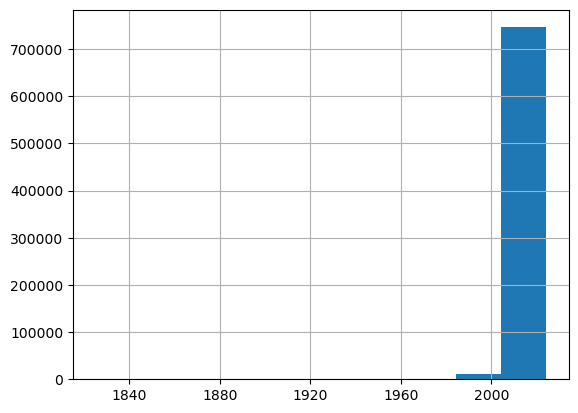

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Izvleček strukturiranih podatkov

Poglejmo, kakšne informacije lahko preprosto izvlečemo iz povzetkov. Ena od stvari, ki bi nas lahko zanimale, je, katere strategije zdravljenja obstajajo in kako so se razvijale skozi čas. Za začetek lahko ročno sestavimo seznam možnih zdravil, ki se uporabljajo za zdravljenje COVID-a, ter tudi seznam diagnoz. Nato jih pregledamo in poiščemo ustrezne izraze v povzetkih člankov.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Dodali smo več stolpcev v naš dataframe, ki vsebujejo število pojavitev določene zdravila/diagnoze v povzetku.

> **Opomba**: Pri iskanju podniza dodamo presledek na začetek besede. Če tega ne storimo, lahko dobimo napačne rezultate, saj bi se *klorokin* našel tudi znotraj podniza *hidroksiklorokin*. Prav tako prisilimo pretvorbo stolpca povzetkov v `str`, da se izognemo napaki - poskusite odstraniti `str` in preverite, kaj se zgodi.

Da bi olajšali delo s podatki, lahko izluščimo pod-okvir, ki vsebuje samo število pojavitev zdravil, in izračunamo skupno število pojavitev. To nam pokaže najbolj priljubljeno zdravilo:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

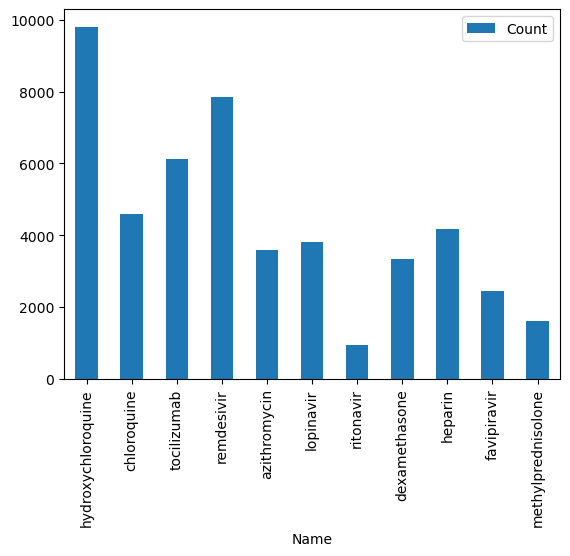

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Iskanje trendov v strategiji zdravljenja

V zgornjem primeru smo sešteli vse vrednosti, vendar lahko enako naredimo tudi na mesečni ravni:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

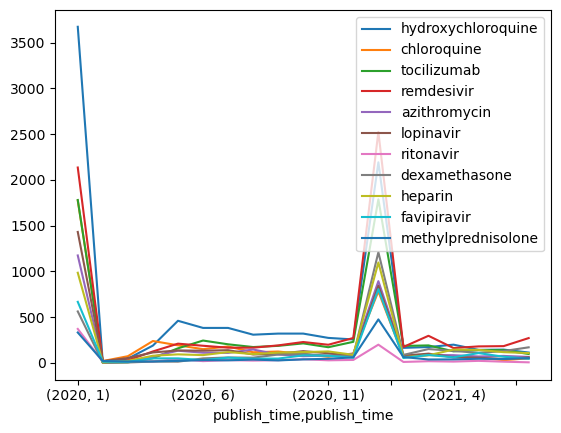

In [152]:
dfmt.plot()
plt.show()

Zanimiva ugotovitev je, da imamo velike konice na dveh lokacijah: januar 2020 in januar 2021. To je posledica dejstva, da nekateri članki nimajo jasno določenega datuma objave, zato so označeni kot januar ustreznega leta.

Da bi podatki imeli več smisla, si oglejmo le nekaj zdravil. Prav tako bomo "izbrisali" podatke za januar in jih nadomestili z neko srednjo vrednostjo, da bo graf lepši:


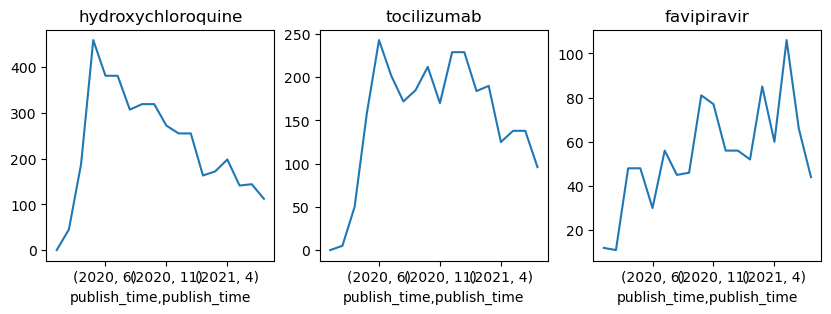

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

Opazite, kako je priljubljenost hidroksiklorokina naraščala v prvih nekaj mesecih, nato pa začela upadati, medtem ko število omemb favipiravirja kaže stabilno rast. Drug dober način za vizualizacijo relativne priljubljenosti je uporaba **zloženega grafa** (ali **graf območja** v terminologiji Pandas):


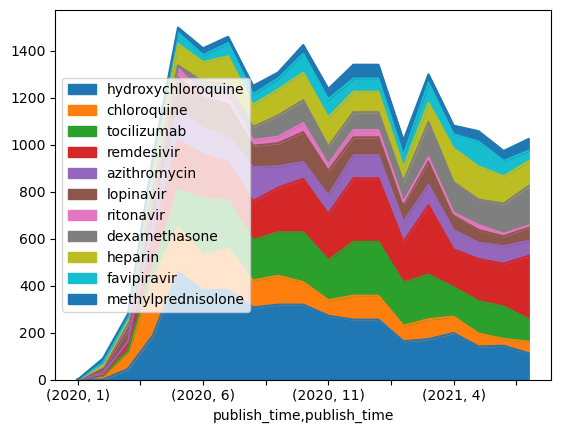

In [154]:
dfmt.plot.area()
plt.show()

Še dlje lahko izračunamo relativno priljubljenost v odstotkih:


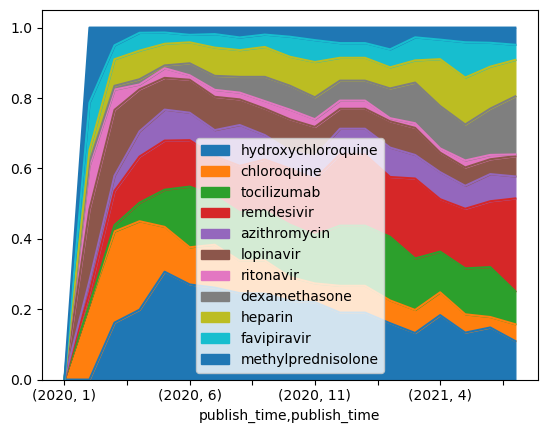

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Povezava med zdravili in diagnozami

Ena najbolj zanimivih povezav, ki jih lahko raziskujemo, je, kako se različne diagnoze zdravijo z različnimi zdravili. Da bi to vizualizirali, moramo izračunati **zemljevid pogostosti so-omemb**, ki prikazuje, kolikokrat sta dva izraza omenjena v istem članku.

Tak zemljevid je v bistvu 2D matrika, ki jo najbolje predstavlja **numpy array**. Ta zemljevid bomo izračunali tako, da pregledamo vse povzetke in označimo entitete, ki se tam pojavljajo:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Eden od načinov za vizualizacijo te matrike je risanje **toplotne karte**:


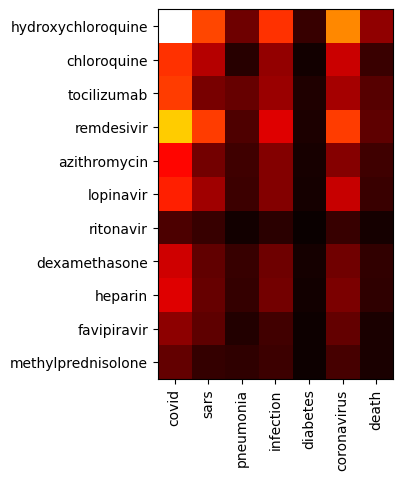

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Vendar pa je še boljša vizualizacija možna z uporabo tako imenovanega **Sankey** diagrama! `matplotlib` nima vgrajene podpore za to vrsto diagrama, zato bomo morali uporabiti [Plotly](https://plotly.com/python/), kot je opisano [v tem vodiču](https://plotly.com/python/sankey-diagram/).

Za izdelavo Sankey diagrama s Plotly moramo sestaviti naslednje sezname:
* Seznam `all_nodes` vseh vozlišč v grafu, ki bo vključeval tako zdravila kot diagnoze
* Seznam indeksov virov in ciljev - ti seznami bodo pokazali, katera vozlišča gredo na levo in katera na desno stran diagrama
* Seznam vseh povezav, pri čemer vsaka povezava vsebuje:
   - Indeks vira v tabeli `all_nodes`
   - Indeks cilja
   - Vrednost, ki označuje moč povezave. To je točno vrednost iz naše matrike so-pojavitev.
   - Po želji barvo povezave. Dodali bomo možnost, da poudarimo nekatere izraze za večjo jasnost.

Splošna koda za risanje Sankey diagrama je strukturirana kot ločena funkcija `sankey`, ki sprejme dva seznama (kategorije virov in ciljev) ter matriko so-pojavitev. Prav tako nam omogoča, da določimo prag in izpustimo vse povezave, ki so šibkejše od tega praga - to naredi diagram nekoliko manj zapleten.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Zaključek

Videli ste, da lahko z dokaj preprostimi metodami pridobimo informacije iz nestrukturiranih virov podatkov, kot je besedilo. V tem primeru smo uporabili obstoječi seznam zdravil, vendar bi bilo veliko bolj učinkovito uporabiti tehnike obdelave naravnega jezika (NLP) za ekstrakcijo entitet iz besedila. V [tem blog prispevku](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) opisujemo, kako uporabiti storitve v oblaku za ekstrakcijo entitet. Druga možnost je uporaba Python knjižnic za NLP, kot je [NLTK](https://www.nltk.org/) - pristop za pridobivanje informacij iz besedila z uporabo NLTK je opisan [tukaj](https://www.nltk.org/book/ch07.html).


## Izziv

Nadaljujte z raziskovanjem podatkov iz člankov o COVID-19 v naslednjih smereh:

1. Zgradite matriko so-pojavnosti različnih zdravil in preverite, katera zdravila se pogosto pojavljajo skupaj (tj. omenjena v enem povzetku). Kodo za gradnjo matrike so-pojavnosti za zdravila in diagnoze lahko prilagodite.
1. Vizualizirajte to matriko s pomočjo toplotne karte.
1. Kot dodatni izziv lahko poskusite vizualizirati so-pojavnost zdravil z uporabo [krožnega diagrama](https://en.wikipedia.org/wiki/Chord_diagram). [Ta knjižnica](https://pypi.org/project/chord/) vam lahko pomaga narisati krožni diagram.
1. Kot še en dodatni izziv poskusite izluščiti odmerke različnih zdravil (na primer **400mg** v *vzemite 400mg klorokina dnevno*) z uporabo regularnih izrazov in zgradite podatkovni okvir, ki prikazuje različne odmerke za različna zdravila. **Opomba**: upoštevajte številske vrednosti, ki so v neposredni besedilni bližini imena zdravila.



---

**Omejitev odgovornosti**:  
Ta dokument je bil preveden z uporabo storitve za strojno prevajanje [Co-op Translator](https://github.com/Azure/co-op-translator). Čeprav si prizadevamo za natančnost, vas opozarjamo, da lahko avtomatizirani prevodi vsebujejo napake ali netočnosti. Izvirni dokument v njegovem izvirnem jeziku je treba obravnavati kot avtoritativni vir. Za ključne informacije priporočamo strokovno človeško prevajanje. Ne prevzemamo odgovornosti za morebitna nesporazumevanja ali napačne razlage, ki bi izhajale iz uporabe tega prevoda.
